# Image Super-Resolution Demo

## Imports

In [9]:
from google.colab import drive
import zipfile
import shutil
from skimage import io
import json

from matplotlib import pyplot as plt
import numpy as np
import os
import math
import cv2

import random as python_random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras import layers, Model

import warnings
import time

np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)
keras.utils.set_random_seed(0)
cv2.setRNGSeed(0)
drive.mount('/content/drive')

import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

Mounted at /content/drive


## Necessary Functions

In [10]:
def split_image2(image, target_size=(1000, 1000), output_size=(244, 244)):
    h, w, _ = image.shape
    output_h, output_w = output_size
    target_h, target_w = target_size

    # If the image is smaller than the target size, discard the image
    if h <= target_h or w <= target_w:
        return None

    # Calculates the amount of images per axis
    tot_images_x = math.ceil(w / output_w)
    tot_images_y = math.ceil(h / output_h)

    # Calculate the amount of sliding per axis
    slide_w = (w - target_w) / (tot_images_x - 1)
    slide_h = (h - target_h) / (tot_images_y - 1)

    # Initialize a list to hold rows of cropped patches
    matrix = []

    # Extracts the patches row by row
    for j in range(tot_images_y):
        row_patches = []
        for i in range(tot_images_x):
            start_w = int(round(slide_w * i))
            start_h = int(round(slide_h * j))

            # Ensure the patch doesn't exceed image boundaries
            start_w = min(start_w, w - target_w)
            start_h = min(start_h, h - target_h)

            end_w = start_w + target_w
            end_h = start_h + target_h

            cropped = image[start_h:end_h, start_w:end_w]
            row_patches.append(cropped)
        matrix.append(row_patches)

    # Converts the list of lists to a 4D NumPy array
    matrix = np.array(matrix)
    return matrix

In [11]:
# Preprocessing Function
def preprocess_image(image, scale_factor=2, input_size=(33, 33), output_size=(33, 33)):
    hr = resize(image, input_size, anti_aliasing=True) # Resize the input image to the desired high-resolution size

    blurred_image = cv2.GaussianBlur(hr, (5, 5), 1) # Apply Gaussian blur to the high-resolution image
    low_res_image = blurred_image[::scale_factor, ::scale_factor] # Sub-sample the image by the scale factor to get the low resolution image
    # Upscale the low-resolution image back to the original high-resolution size using bicubic interpolation
    height, width = hr.shape[:2]
    lr = cv2.resize(low_res_image, (width, height), interpolation=cv2.INTER_CUBIC)

    if output_size != input_size:
        # Crop the border of hr to match the output_size
        start_x = (hr.shape[0] - output_size[0]) // 2
        start_y = (hr.shape[1] - output_size[1]) // 2
        hr = hr[start_x:start_x + output_size[0], start_y:start_y + output_size[1]]
    return lr, hr

In [12]:
def process_image_matrix(matrix, model, scale_factor, input_size, output_size, verbose=0):
    # Initialize lists to hold rows of processed patches, cropped LR images, and original HR images
    pred_matrix = []
    lr_matrix = []
    hr_matrix = []

    # Iterate over each row of the matrix
    for row in matrix:
        pred_row = []
        lr_row = []
        hr_row = []
        for img in row:
            # Preprocess the image
            lr, hr = preprocess_image(img, scale_factor=scale_factor, input_size=input_size, output_size=output_size)

            # Predict using the model
            pred = model.predict(np.expand_dims(lr, axis=0), verbose=verbose)[0]

            # Crop lr to match the pred size, for comparison purposes
            crop_x = (lr.shape[0] - pred.shape[0]) // 2
            crop_y = (lr.shape[1] - pred.shape[1]) // 2
            lr_cropped = lr[crop_x:crop_x + pred.shape[0], crop_y:crop_y + pred.shape[1]]

            # Append the processed data to their respective rows
            pred_row.append(pred)
            lr_row.append(lr_cropped)
            hr_row.append(hr)
        pred_matrix.append(pred_row)
        lr_matrix.append(lr_row)
        hr_matrix.append(hr_row)

    # Convert the lists of lists to 4D NumPy arrays
    pred_matrix = np.array(pred_matrix)
    lr_matrix = np.array(lr_matrix)
    hr_matrix = np.array(hr_matrix)

    return lr_matrix, pred_matrix, hr_matrix

In [13]:
def reconstruct_image(matrix, original_image, target_size=(244, 244), reduced_size=(21,21)):
    h, w, _ = original_image.shape
    target_h, target_w = target_size

    # Adjust the dimensions based on the reduced size
    h = h - reduced_size[0]
    w = w - reduced_size[1]

    final_image = np.zeros((h, w, 3), dtype=np.float32)

    # Calculates the amount of images per axis
    tot_images_x = len(matrix[0])
    tot_images_y = len(matrix)

    # Calculate the sliding per axis to evenly distribute overlap
    slide_w = (w - target_w) / (tot_images_x - 1) if tot_images_x > 1 else 0
    slide_h = (h - target_h) / (tot_images_y - 1) if tot_images_y > 1 else 0

    # Extracts the patches
    for j, row in enumerate(matrix):
        for i, patch in enumerate(row):
            # Calculate the starting position for each patch
            start_w = int(round(slide_w * i))
            start_h = int(round(slide_h * j))

            # Ensure the patch doesn't exceed the image boundaries
            start_w = min(start_w, w - target_w)
            start_h = min(start_h, h - target_h)

            end_w = start_w + target_w
            end_h = start_h + target_h

            # Place the patch in the final image
            final_image[start_h:end_h, start_w:end_w] = patch[:end_h - start_h, :end_w - start_w]

    return final_image

In [14]:
def calculate_psnr(img1, img2):
    # Scale images from [0, 1] to [0, 255] and convert to int8
    img1 = (img1 * 255).astype(np.uint8)
    img2 = (img2 * 255).astype(np.uint8)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100  # Perfect match

    # Calculate PSNR
    psnr = 20 * np.log10(255.0 / math.sqrt(mse))
    return psnr

In [15]:
def display_comparison2(lr, pred, hr):
    # Calculate PSNR between LR and HR (baseline)
    psnr_lr_hr = calculate_psnr(lr, hr)

    # Calculate PSNR between Predicted and HR
    psnr_pred_hr = calculate_psnr(pred, hr)

    # Calculate SSIM between LR and HR (baseline)
    ssim_value_lr, _ = ssim(lr, hr, full=True, channel_axis=-1, data_range=1.0)

    # Calculate PSNR between Predicted and HR
    ssim_value_pred, _ = ssim(pred, hr, full=True, channel_axis=-1, data_range=1.0)

    # Display PSNR values
    print(f"PSNR between LR and HR: {psnr_lr_hr:.2f} dB")
    print(f"PSNR between Predicted and HR: {psnr_pred_hr:.2f} dB")
    print(f"SSIM between LR and HR: {ssim_value_lr:.2f}")
    print(f"SSIM between Predicted and HR: {ssim_value_pred:.2f}")

    # Plot the images
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 3, 1)
    plt.title('Low-Resolution')
    plt.imshow(lr)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Prediction')
    plt.imshow(np.clip(pred, 0, 1))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Original')
    plt.imshow(hr)
    plt.axis('off')

    plt.show()

In [16]:
def display_comparison3(lr, pred, hr, figsize=None, subplot_size=None):
    # Calculate PSNR between LR and HR (baseline)
    psnr_lr_hr = calculate_psnr(lr, hr)

    # Calculate PSNR between Predicted and HR
    psnr_pred_hr = calculate_psnr(pred, hr)

    # Calculate SSIM between LR and HR (baseline)
    ssim_value_lr, _ = ssim(lr, hr, full=True, channel_axis=-1, data_range=1.0)

    # Calculate PSNR between Predicted and HR
    ssim_value_pred, _ = ssim(pred, hr, full=True, channel_axis=-1, data_range=1.0)

    # Display PSNR values
    print(f"PSNR between LR and HR: {psnr_lr_hr:.2f} dB")
    print(f"PSNR between Predicted and HR: {psnr_pred_hr:.2f} dB")
    print(f"SSIM between LR and HR: {ssim_value_lr:.2f}")
    print(f"SSIM between Predicted and HR: {ssim_value_pred:.2f}")

   # Create the figure and subplots
    if figsize is not None:
        fig, axes = plt.subplots(3, 1, figsize=figsize)  # 3 rows, 1 column for vertical layout
    else:
        fig, axes = plt.subplots(3, 1)  # Default figure size

    if subplot_size is not None:
        for ax in axes:
            ax.set_aspect('equal')  # Maintain aspect ratio
            ax.set_adjustable('box')  # Adjust subplot size
            fig.set_figwidth(subplot_size[0])  # Set subplot width
            fig.set_figheight(subplot_size[1] * 3)  # Set subplot height (3 for 3 subplots)

    # Plot the images
    axes[0].imshow(lr)
    axes[0].set_title('Low-Resolution')
    axes[0].axis('off')

    axes[1].imshow(np.clip(pred, 0, 1))
    axes[1].set_title('Prediction')
    axes[1].axis('off')

    axes[2].imshow(hr)
    axes[2].set_title('Original')
    axes[2].axis('off')

    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    plt.show()

## Demo with Full Image Reconstruction

In [17]:
model_path = '/content/drive/My Drive/SRCNN Models/srcnn_model6.keras' # 2x scale factor, 256x256 input, best SRCNN model
model = load_model(model_path)

scale_factor_split = 2

print("Model loaded successfully.")

Model loaded successfully.


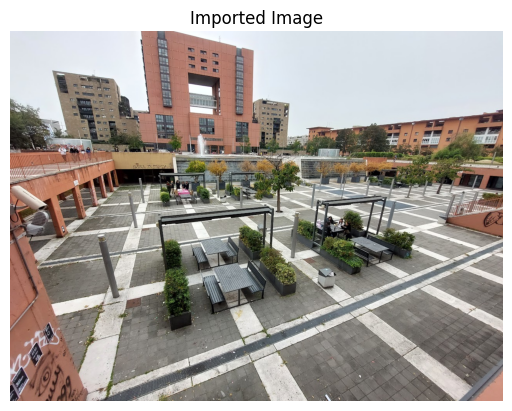

In [22]:
image_path = '13.jpg'
image = io.imread(image_path)

plt.imshow(image)
plt.axis('off')
plt.title("Imported Image")
plt.show()

In [23]:
input_size = (256,256)
reduced_output_size=(235,235)
split_image_matrix = split_image2(image, target_size=input_size, output_size=reduced_output_size)

In [24]:
output_size=(244,244)
lr_matrix, pred_matrix, hr_matrix = process_image_matrix(split_image_matrix, model, scale_factor=scale_factor_split, input_size=input_size, output_size=output_size, verbose=0)

In [25]:
reconstructed_pred = reconstruct_image(pred_matrix, image)
reconstructed_hr = reconstruct_image(hr_matrix, image)
reconstructed_lr = reconstruct_image(lr_matrix, image)
reconstructed_comparison_set = [ (reconstructed_lr, reconstructed_pred, reconstructed_hr) ]

PSNR between LR and HR: 31.42 dB
PSNR between Predicted and HR: 31.61 dB
SSIM between LR and HR: 0.72
SSIM between Predicted and HR: 0.81


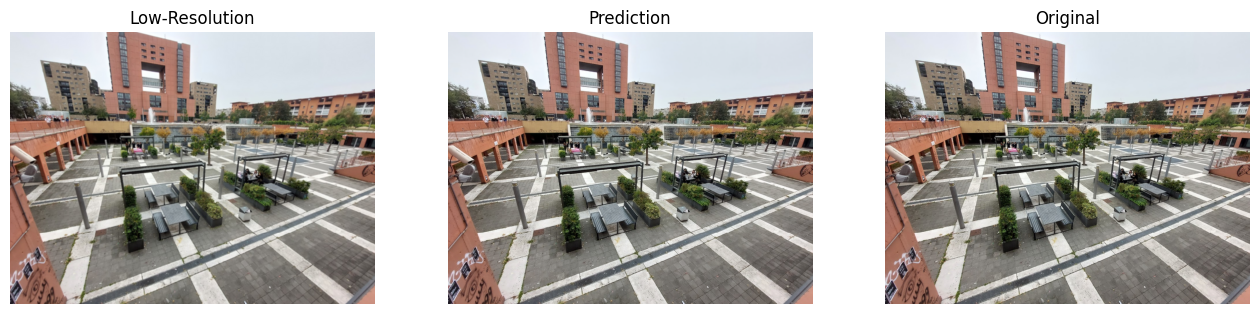

In [26]:
display_comparison2(*reconstructed_comparison_set[0])

PSNR between LR and HR: 31.42 dB
PSNR between Predicted and HR: 31.61 dB
SSIM between LR and HR: 0.72
SSIM between Predicted and HR: 0.81


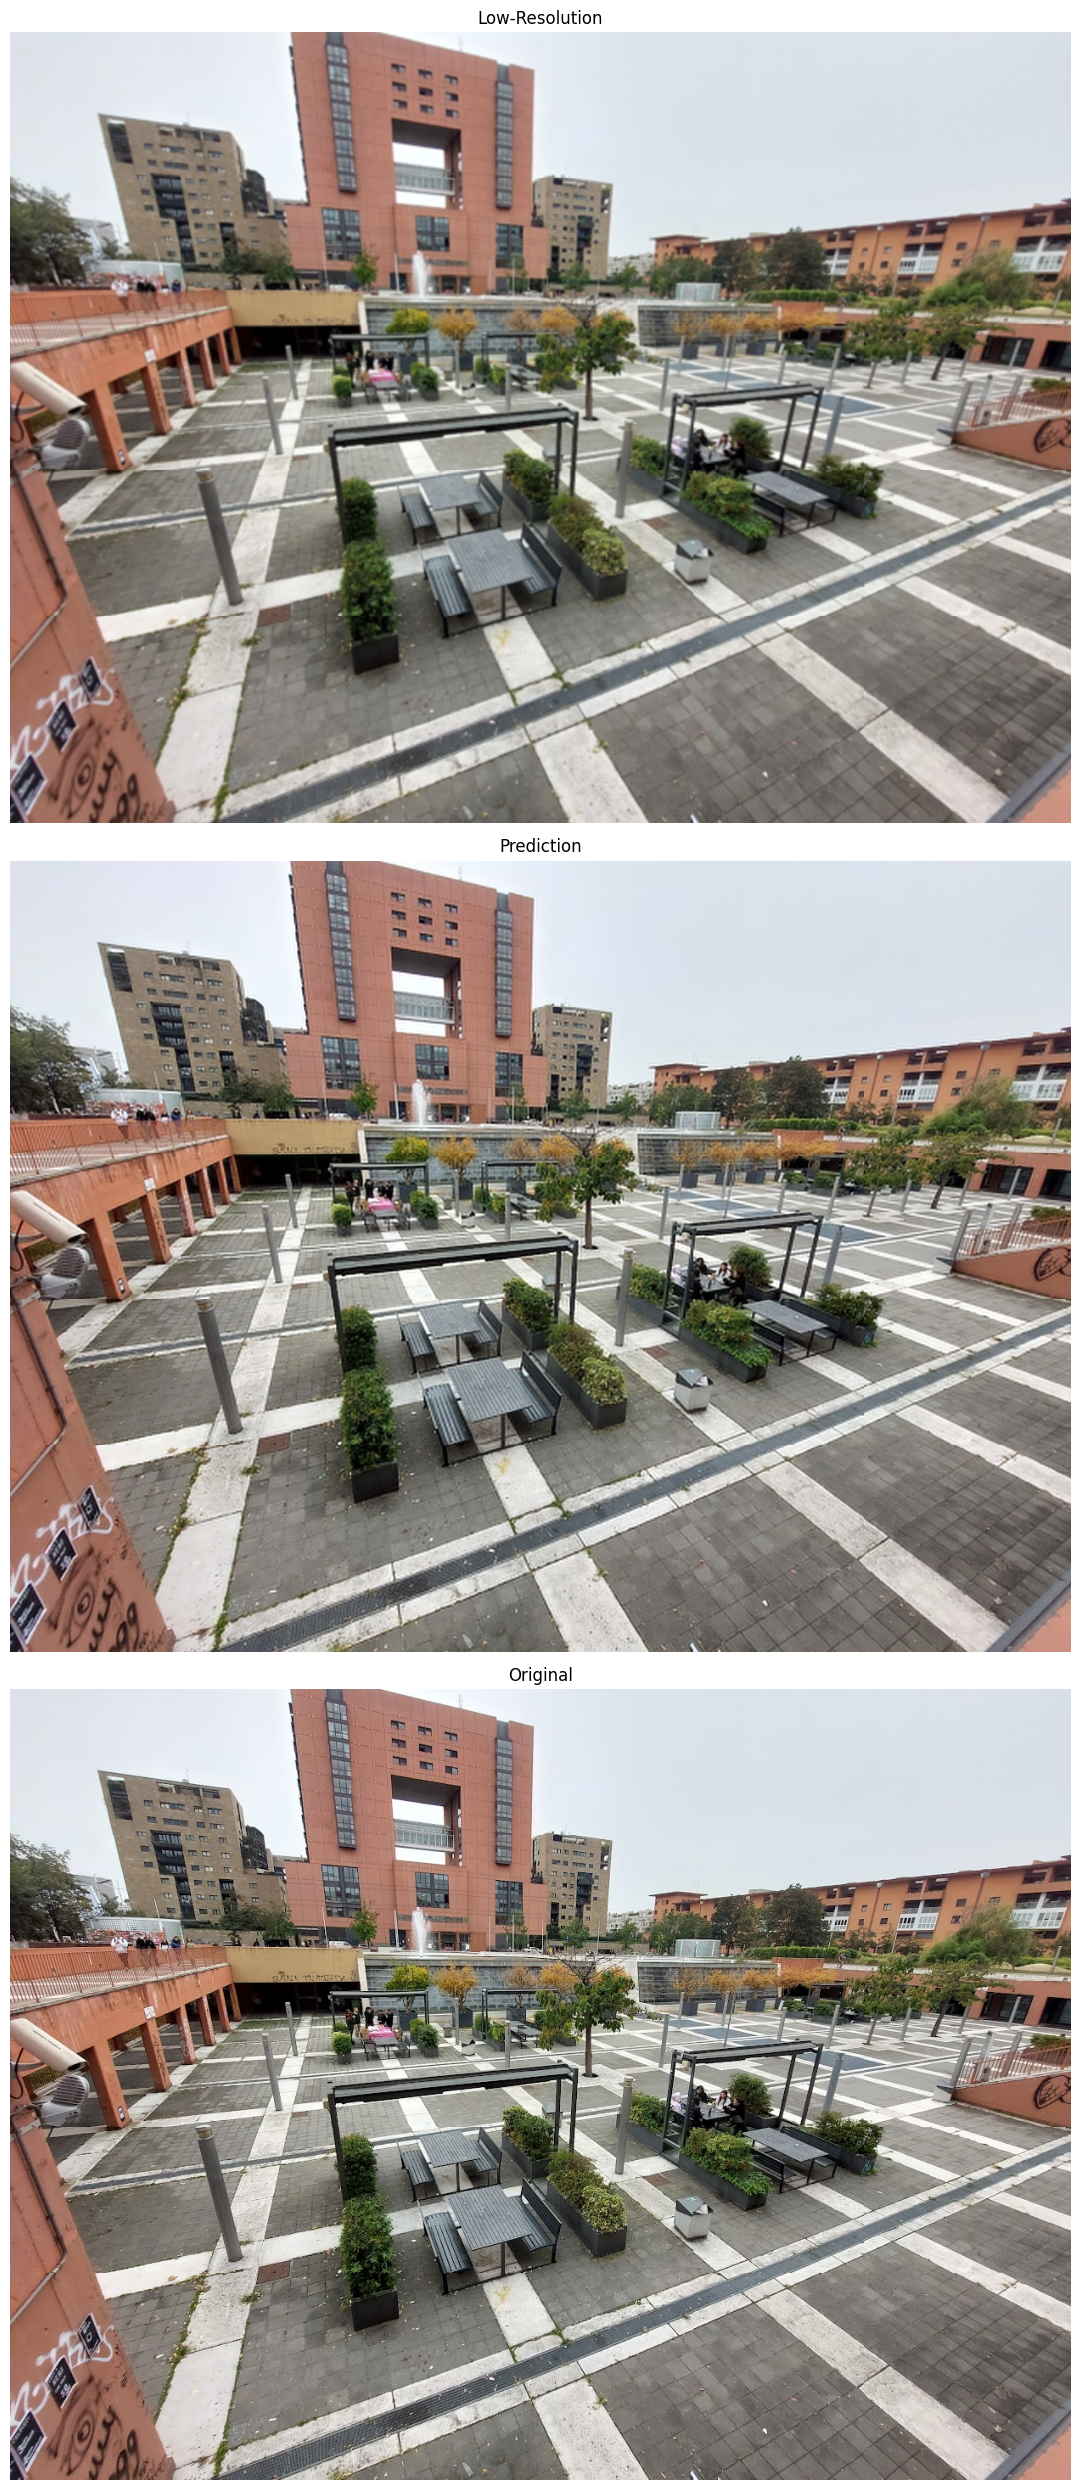

In [27]:
display_comparison3(*reconstructed_comparison_set[0], figsize=(20, 25))

## Others

### Functions

In [28]:
# Preprocessing Function
def preprocess_image2(image, scale_factor=2, output_size=(33, 33)):
    hr = resize(image, output_size, anti_aliasing=True)  # Resize only if necessary

    blurred_image = cv2.GaussianBlur(hr, (5, 5), 1) # Apply Gaussian blur to the high-resolution image
    lr = blurred_image[::scale_factor, ::scale_factor] # Sub-sample the image by the scale factor to get the low resolution image
    return lr, hr

In [29]:
# Data Generator
def data_generator2(folder_path, batch_size=16, scale_factor=2, output_size=(33, 33)):
    # Get a list of all image file paths in the given folder
    image_files = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    num_images = len(image_files)

    # Infinite loop for continuous data generation
    while True:
        np.random.shuffle(image_files) # Shuffle the image file list to introduce randomness in training
        # Creates the batches of the needed size
        for i in range(0, num_images, batch_size):
            batch_files = image_files[i:i+batch_size] # Select a subset of images for the current batch
            lr_images, hr_images = [], []
            for file in batch_files:
                img = plt.imread(file) # Load the image
                if img.shape[-1] == 4: # Handle images with alpha channel (PNG transparency channel) by removing it if it exists, keeping only the RGB channels
                    img = img[..., :3]
                lr, hr = preprocess_image2(img, scale_factor=scale_factor, output_size=output_size) # Create low-resolution and high-resolution pairs
                lr_images.append(lr)
                hr_images.append(hr)

            yield np.array(lr_images), np.array(hr_images) # Convert lists to NumPy arrays and yield them as a batch


In [30]:
def predict_and_evaluate4(folder_path, model, scale_factor=2, num_images=None, output_size=(33, 33), index_image=None, print_average=True, dont_print_pred_process=False):
    # Get list of image files in the folder, sorted by creation time
    image_files = sorted([os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith(('.png', '.jpg', '.jpeg'))], key=os.path.getctime)
    # If num_images is specified, limit the number of images
    if num_images is not None:
        image_files = image_files[:num_images]
    # If index_image is specified, only evaluate that image
    if index_image is not None:
        image_files = [image_files[index_image]]
    # If the dont_print_pred_process flag is true, mute the pred process outputs
    verbose = 1
    if dont_print_pred_process:
        verbose = 0
        print("Predicting...")

    psnrs_pred_hr = []
    psnrs_lr_hr = []
    ssims_pred_hr = []
    ssims_lr_hr = []
    comparisons = []

    for file in image_files:
        img = plt.imread(file)
        if img.shape[-1] == 4:  # Handle images with alpha channel by removing the transparency channel
            img = img[..., :3]
        lr, hr = preprocess_image2(img, scale_factor=scale_factor, output_size=output_size)

        pred = model.predict(np.expand_dims(lr, axis=0), verbose=verbose)[0] # Predict

        # Bicubic interpolation to scale up LR to the size of HR
        lr = cv2.resize(lr, (hr.shape[1], hr.shape[0]), interpolation=cv2.INTER_CUBIC)

        # Calculate PSNR between predicted and HR images
        psnr_lr_hr = calculate_psnr(lr, hr)
        psnrs_lr_hr.append(psnr_lr_hr)
        psnr_pred_hr = calculate_psnr(pred, hr)
        psnrs_pred_hr.append(psnr_pred_hr)

        # Calculate SSIM between predicted and HR images
        ssim_value_lr, _ = ssim(lr, hr, full=True, channel_axis=-1, data_range=1.0)
        ssims_lr_hr.append(ssim_value_lr)
        ssim_value_pred, _ = ssim(pred, hr, full=True, channel_axis=-1, data_range=1.0)
        ssims_pred_hr.append(ssim_value_pred)

        comparisons.append((lr, pred, hr))

    if print_average:
        print(f"Average PSNR between low resolution images (bicubic interpolation) and high-resolution images: {np.mean(psnrs_lr_hr):.2f} dB")
        print(f"Average PSNR between predicted images and high-resolution images: {np.mean(psnrs_pred_hr):.2f} dB")
        print(f"Average SSIM between low resolution images (bicubic interpolation) and high-resolution images: {np.mean(ssims_lr_hr):.4f}")
        print(f"Average SSIM between predicted images and high-resolution images: {np.mean(ssims_pred_hr):.4f}")
    return comparisons

In [31]:
def build_fsrcnn(scale, d=56, s=12, m=4):
    input_layer = layers.Input(shape=(None, None, 3), name="input")

    # Feature extraction layer
    x = layers.Conv2D(d, kernel_size=5, strides=1, padding="same", activation="relu", name="feature_extraction")(input_layer)

    # Shrinking layer
    x = layers.Conv2D(s, kernel_size=1, strides=1, padding="same", activation="relu", name="shrinking")(x)

    # Mapping layers
    for i in range(m):
        x = layers.Conv2D(s, kernel_size=3, strides=1, padding="same", activation="relu", name=f"mapping_{i+1}")(x)

    # Expanding layer
    x = layers.Conv2D(d, kernel_size=1, strides=1, padding="same", activation="relu", name="expanding")(x)

    # Deconvolution layer
    output_layer = layers.Conv2DTranspose(
        3,
        kernel_size=9,
        strides=scale,
        padding="same",
        activation="linear",
        name="deconvolution"
    )(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [32]:
fsrcnn_model = build_fsrcnn(scale=2)
fsrcnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_extraction (Conv2D)          │ (None, None, None, 56)      │           4,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ shrinking (Conv2D)                   │ (None, None, None, 12)      │             684 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mapping_1 (Conv2D)                   │ (None, None, None, 12)      │           1,308 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mapping_2 (Conv2D)                   │ (None, None, None, 12)      │           1,308 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mapping_3 (Conv2D)                   │ (None, None, None, 12)      │           1,308 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mapping_4 (Conv2D)                   │ (None, None, None, 12)      │           1,308 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expanding (Conv2D)                   │ (None, None, None, 56)      │             728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ deconvolution (Conv2DTranspose)      │ (None, None, None, 3)       │          13,611 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,511 (95.75 KB)

 Trainable params: 24,511 (95.75 KB)

 Non-trainable params: 0 (0.00 B)

### Dataset preparation

In [33]:
def delete_grayscale_images(folder_path):
    deleted_count = 0
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            # Load the image
            image = cv2.imread(file_path)

            # Ensure the file is an image
            if image is None:
                continue

            # Check if the image is effectively grayscale
            if len(image.shape) == 2 or (len(image.shape) == 3 and np.all(image[:, :, 0] == image[:, :, 1]) and np.all(image[:, :, 1] == image[:, :, 2])):
                os.remove(file_path)
                deleted_count += 1
        except Exception as e:
            print(f"Error processing or deleting file {file_path}: {e}")

    return deleted_count

In [34]:
# Transfer dataset, and extract files
shutil.copy('/content/drive/My Drive/arcDatasetSmallDemo.zip', 'arcDatasetSmallDemo.zip')
zipf = zipfile.ZipFile('arcDatasetSmallDemo.zip')
zipf.extractall()
zipf.close()

os.remove('arcDatasetSmallDemo.zip') # Delete the copied zip file

In [35]:
def create_dataset_2(source_path, destination_path, train_proportion=0.7, val_proportion=0.2, test_proportion=0.1):
    # Define paths for the new dataset structure
    dataset_path = 'mammalsdataset'
    os.makedirs(destination_path, exist_ok=True)

    # Create subdirectories for train, val, and test
    for subfolder in ['train', 'val', 'test']:
        os.makedirs(os.path.join(destination_path, subfolder), exist_ok=True)

    fodlers = sorted(os.listdir(source_path))
    # Loop over each folder in the original dataset
    for folder in fodlers:
        dataset_folder = os.path.join(source_path, folder)
        if os.path.isdir(dataset_folder):
            # Get all images in the current folder
            images = sorted([f for f in os.listdir(dataset_folder) if os.path.isfile(os.path.join(dataset_folder, f))])

            # Shuffle the images to randomize the split
            python_random.shuffle(images)

            # Calculate split sizes based on proportions
            total_images = len(images)
            train_size = int(train_proportion * total_images)
            val_size = int(val_proportion * total_images)
            test_size = total_images - train_size - val_size

            # Split the images into train, val, and test
            train_images = images[:train_size]
            val_images = images[train_size:train_size + val_size]
            test_images = images[train_size + val_size:]

            # Move images into the corresponding folders
            for img in train_images:
                shutil.move(os.path.join(dataset_folder, img), os.path.join(destination_path, 'train', img))
            for img in val_images:
                shutil.move(os.path.join(dataset_folder, img), os.path.join(destination_path, 'val', img))
            for img in test_images:
                shutil.move(os.path.join(dataset_folder, img), os.path.join(destination_path, 'test', img))

    shutil.rmtree(source_path)
    print(f"Dataset has been created at {destination_path}")


In [36]:
# Check if the dataset exists, if not, create it
dataset_path = 'architecturedataset'
source_path = 'arcDatasetSmallDemo'
if not os.path.exists(dataset_path):
    create_dataset_2(source_path, dataset_path, train_proportion=0.7, val_proportion=0.2, test_proportion=0.1)
else:
    print("Dataset already exists.")

# Count the number of images in each of the subfolders: train, val, and test
train_images = len([f for f in os.listdir(os.path.join(dataset_path, 'train')) if os.path.isfile(os.path.join(dataset_path, 'train', f))])
val_images = len([f for f in os.listdir(os.path.join(dataset_path, 'val')) if os.path.isfile(os.path.join(dataset_path, 'val', f))])
test_images = len([f for f in os.listdir(os.path.join(dataset_path, 'test')) if os.path.isfile(os.path.join(dataset_path, 'test', f))])

# Print the results
print(f"Number of images in train: {train_images}")
print(f"Number of images in val: {val_images}")
print(f"Number of images in test: {test_images}")

Dataset has been created at architecturedataset
Number of images in train: 50
Number of images in val: 0
Number of images in test: 25


In [37]:
print("Train grayscale images deleted: ", delete_grayscale_images("architecturedataset/train"))
print("Val grayscale images deleted: ", delete_grayscale_images("architecturedataset/val"))
print("Test grayscale images deleted: ", delete_grayscale_images("architecturedataset/test"))

Train grayscale images deleted:  1
Val grayscale images deleted:  0
Test grayscale images deleted:  0


In [38]:
def create_dataset(source_path, destination_path_train, destination_path_validation, image_target_size, split=0.75):
    imported_image_count = 0
    augmented_image_count = 0

    # Calculates the train/val split
    tot_images_in_dataset = len(os.listdir(source_path))
    train_index_max = int(tot_images_in_dataset * split)

    start_index = 0
    max_index = len(os.listdir(source_path))
    file_paths = sorted(os.listdir(source_path), reverse=True)

    for i in range(start_index, max_index):
        if(i < train_index_max):
            destination_path = destination_path_train
        else:
            destination_path = destination_path_validation

        filename = file_paths[i]
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(source_path, filename)
            #print("Importing", filename)
            image = io.imread(image_path)
            split_images = split_image(image, image_target_size)

            if split_images is not None:
                # Create subfolders in train/val folder
                for j, cropped_image in enumerate(split_images):
                    # Generate a new filename for each cropped image (to avoid overwriting)
                    new_filename = f"{os.path.splitext(filename)[0]}_split_{i}_{j}.jpg"
                    save_path = os.path.join(destination_path, new_filename)

                    # Save the cropped image
                    io.imsave(save_path, cropped_image)
                augmented_image_count += len(split_images)

            imported_image_count += 1

    return imported_image_count, augmented_image_count  # Return the number of imported images and augmented images

In [39]:
def split_image(image, target_size=(1000, 1000)):
    h, w, _ = image.shape
    target_h, target_w = target_size
    #print(w, h)

    # If the image is smaller than the target size, discard the image
    if h <= target_h or w <= target_w:
        #print(f"The image size ({h}, {w}) is smaller than the target size ({target_h}, {target_w}), discarding image.")
        return None

    cropped_images = [] # List to store the cropped images

    # Calculates the amount of images per axis
    tot_images_x = math.ceil(w/target_w)
    tot_images_y = math.ceil(h/target_h)

    # Calculates the amount of sliding per axis, so that each cropped image is as far as possible to the others and the amount of overlappings are equally distributed
    slide_w=int(w/tot_images_x)
    slide_h=int(h/tot_images_y)

    # Extracts the patches
    for j in range(tot_images_y):
        for i in range(tot_images_x):
            start_w = slide_w * i
            start_h = slide_h * j
            if(start_w + target_w > w):
                start_w = w-target_w
            if(start_h + target_h > h):
                start_h = h - target_h

            end_w = start_w + target_w
            end_h = start_h + target_h
            #print(start_w, end_w, start_h, end_h)

            cropped = image[start_h:end_h, start_w:end_w]
            #print("shape:", cropped.shape)
            cropped_images.append(cropped)

    # Converts the list of cropped images to a NumPy array
    return cropped_images

In [40]:
warnings.filterwarnings("ignore", category=UserWarning, module="skimage")

In [41]:
source_path_train = "architecturedataset/train"
source_path_val = "architecturedataset/val"
source_path_test = "architecturedataset/test"
train_path_destination = "dataset3/train"
val_path_destination = "dataset3/val"
test_path_destination = "dataset3/test"
target_size = (256, 256)

# Check if the destination folders exist, if not, create them
if not os.path.exists(train_path_destination):
    os.makedirs(train_path_destination)
    os.makedirs(val_path_destination)
    os.makedirs(test_path_destination)
    imported_image_count, augmented_image_count = create_dataset(source_path_train, train_path_destination, "", target_size, split=1)
    imported_image_count, augmented_image_count = create_dataset(source_path_val, val_path_destination, "", target_size, split=1)
    imported_image_count, augmented_image_count = create_dataset(source_path_test, test_path_destination, "", target_size, split=1)

else:
    print("Destination folders already exist. The dataset probably already exists.")

In [42]:
print("Train images:", len(os.listdir("dataset3/train")))
print("Val images:", len(os.listdir("dataset3/val")))
print("Test images:", len(os.listdir("dataset3/test")))

Train images: 395
Val images: 0
Test images: 195


### FSRCNN 2x scale factor

In [43]:
model_save_path = '/content/drive/My Drive/SRCNN Models/fsrcnn_model3.keras'
scale_factor_fsrcnn3 = 2
train_path_destination = 'dataset3/train'
val_path_destination = 'dataset3/val'
test_path_destination = 'dataset3/test'

# Load the pre-trained model
fsrcnn3 = load_model(model_save_path)
print("Model loaded successfully.")

Model loaded successfully.


In [44]:
# Perform predictions and evaluations
predict_folder = test_path_destination
start_time = time.time()
comparisons_fsrcnn3 = predict_and_evaluate4(predict_folder, fsrcnn3, scale_factor=scale_factor_fsrcnn3, num_images=150, output_size=(244, 244), dont_print_pred_process=True)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Predicting...
Average PSNR between low resolution images (bicubic interpolation) and high-resolution images: 33.26 dB
Average PSNR between predicted images and high-resolution images: 33.06 dB
Average SSIM between low resolution images (bicubic interpolation) and high-resolution images: 0.7942
Average SSIM between predicted images and high-resolution images: 0.8633
Execution time: 79.41 seconds


PSNR between LR and HR: 33.02 dB
PSNR between Predicted and HR: 33.37 dB
SSIM between LR and HR: 0.86
SSIM between Predicted and HR: 0.92


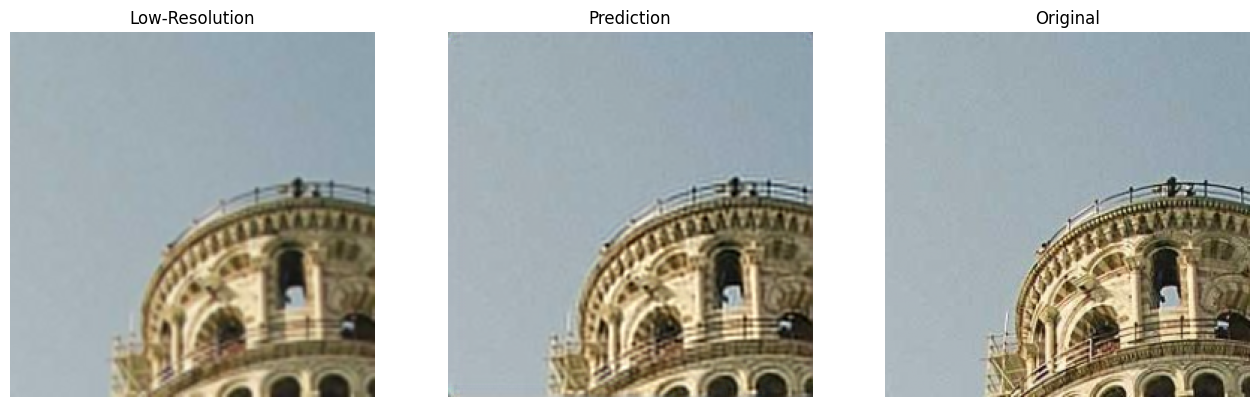

In [45]:
display_comparison2(*comparisons_fsrcnn3[1])

### FSRCNN 3x scale factor

In [46]:
model_save_path = '/content/drive/My Drive/SRCNN Models/fsrcnn_model4.keras'
scale_factor_fsrcnn4 = 3
train_path_destination = 'dataset3/train'
val_path_destination = 'dataset3/val'
test_path_destination = 'dataset3/test'

# Load the pre-trained model
fsrcnn4 = load_model(model_save_path)
print("Model loaded successfully.")

Model loaded successfully.


In [47]:
# Perform predictions and evaluations
predict_folder = test_path_destination
comparisons_fsrcnn4 = predict_and_evaluate4(predict_folder, fsrcnn4, scale_factor=scale_factor_fsrcnn4, num_images=150, output_size=(246, 246), dont_print_pred_process=True)

Predicting...
Average PSNR between low resolution images (bicubic interpolation) and high-resolution images: 32.63 dB
Average PSNR between predicted images and high-resolution images: 32.19 dB
Average SSIM between low resolution images (bicubic interpolation) and high-resolution images: 0.6958
Average SSIM between predicted images and high-resolution images: 0.7608


PSNR between LR and HR: 32.63 dB
PSNR between Predicted and HR: 32.69 dB
SSIM between LR and HR: 0.79
SSIM between Predicted and HR: 0.84


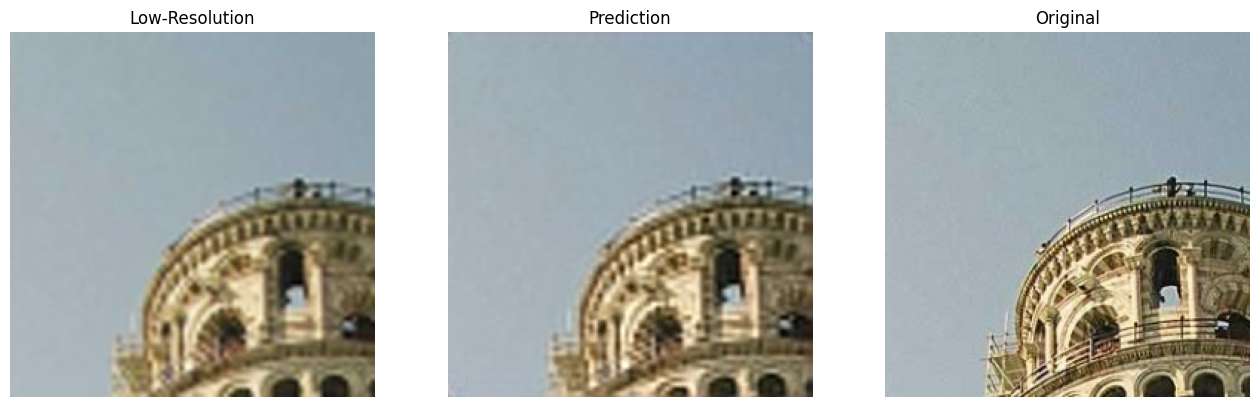

In [48]:
display_comparison2(*comparisons_fsrcnn4[1])